# 2. Trajectory Rewards

Here we extend the idea of using the differentiable pre-trained difficulty evaluator.
However, now we will use a bunch of agents to sample trajectories in the generated
environment. From the total reward of those trajectories we will then compute the
experienced difficulty:

$R_{best} = \max_\mathcal{T} R_\mathcal{T}$

$R_{worst} = \min_\mathcal{T} R_\mathcal{T}$

$\mathcal{D}_\mathcal{T} = \frac{R_{best} - R_\mathcal{T}}{R_{best} - R_{worst}}$


We use the skill of the agents to determine how the experienced difficulties should be
weighted.


In [1]:
import torch
from IPython.display import display, clear_output
from matplotlib import pyplot as plt
from torch.optim import Adam

from helpers import SimpleTRE, x2states
from renderer import render_single_enemy
from shared_parameters import *
from utils import TrainUntil, MLP

Create the actors, each with their own skill. The skill of the actor determines the
randomness in its actions.

$\text{randomness} = 1 - \text{skill}$

We use the truncated skewed normal distribution to determine the weights of each skill.


Create an environment to evaluate the agents. We use the *jitted* version to speed up the evaluation.

Now evaluate the levels with the oracle

In [8]:
oracle = SimpleTRE()

x = np.linspace(enemy_x_min, enemy_x_max, subdivisions)
states = x2states(x)

x = torch.from_numpy(x).type(torch.float32).unsqueeze(1)

difficulties = torch.from_numpy(oracle.evaluate(states)).type(torch.float32).unsqueeze(1)
states = torch.from_numpy(states).type(torch.float32)

Now we can fit our difficulty estimator to the estimates on the levels.

In [9]:
evaluator = MLP(1, 1, [4, 8, 8, 4], activation="lrelu")
optim_evaluator = Adam(evaluator.parameters(), lr=0.001)

with TrainUntil(1e-5, 100, 10000) as trainer:
    while not trainer.done:
        predicted = evaluator(x)

        loss = ((predicted - difficulties) ** 2).mean()

        optim_evaluator.zero_grad()
        loss.backward()
        optim_evaluator.step()

        if (trainer.iteration + 1) % 100 == 0:
            clear_output(wait=True)
            print(trainer.iteration + 1, loss.item())

        trainer.loss = loss

print(trainer.iteration, "iterations to train estimator")

10000 7.970198203111067e-05
Done after 10001 iteration(s). Loss: 0.000080
10001 iterations to train estimator


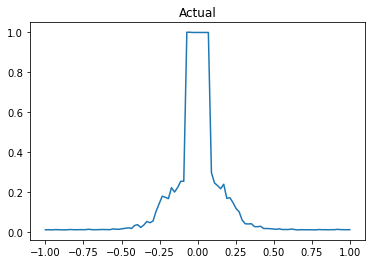

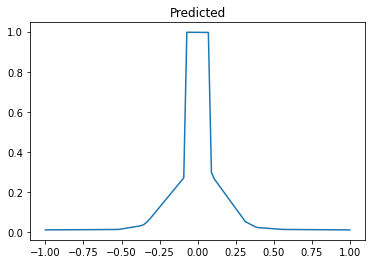

In [10]:
axs = plt.subplot()
axs.plot(x.flatten().numpy(), difficulties)
axs.set_title("Actual")
plt.show()

predicted = evaluator(x)

axs = plt.subplot()
axs.plot(x.flatten().numpy(), predicted.detach().numpy())
axs.set_title("Predicted")
plt.show()


Now we can train our generator. This is exactly the same as in the previous part.

In [11]:
generator = MLP(1, 1, [8, 4], activation="lrelu")
optim_generator = Adam(generator.parameters(), lr=0.005)

d_in = torch.linspace(0, 1, 100).unsqueeze(1)

with TrainUntil(1e-4, 100, 10000) as trainer:
    while not trainer.done:
        states = generator(d_in)

        constrained = states.clamp(enemy_x_min, enemy_x_max)
        constrain_loss = torch.linalg.norm(constrained - states, dim=-1).mean()

        d_out = evaluator(states)

        difficulty_loss = (d_in - d_out).abs().mean()

        loss = difficulty_loss + constrain_loss

        optim_generator.zero_grad()
        loss.backward()
        optim_generator.step()

        if (trainer.iteration + 1) % 100 == 0:
            clear_output(wait=True)
            print(trainer.iteration + 1, difficulty_loss.item(), constrain_loss.item())

        trainer.loss = loss

print(trainer.iteration, trainer.loss.item())

10000 0.0643773153424263 0.0
Done after 10001 iteration(s). Loss: 0.034826
10001 0.03482551872730255


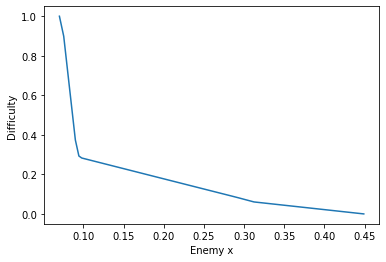

In [12]:
d_in = torch.linspace(0, 1, 100).unsqueeze(1)

with torch.no_grad():
    states = generator(d_in)

states = states.numpy()

axs = plt.subplot()
axs.plot(states, d_in)
axs.set_xlabel("Enemy x")
axs.set_ylabel("Difficulty")
plt.show()

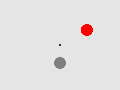

0.0

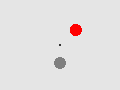

0.1111111119389534

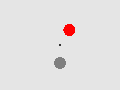

0.2222222238779068

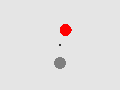

0.3333333432674408

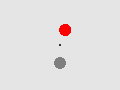

0.4444444477558136

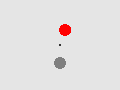

0.5555555820465088

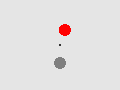

0.6666666269302368

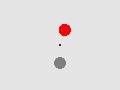

0.7777777910232544

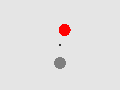

0.8888888955116272

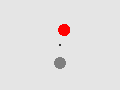

1.0

In [13]:
d_in = torch.linspace(0, 1, 10).unsqueeze(1)

with torch.no_grad():
    enemy_xs = generator(d_in)

images = [render_single_enemy(enemy_x, resolution=0.15) for enemy_x in enemy_xs]

for image, d in zip(images, d_in):
    display(image)
    display(d.item())